# Compare the surface KE simulated by the tide-only 1-layer global MOM6 with SAH drag, 1 coeff, without vs with frequency dependence, $M_2$)

SAH ref: /g/data/nm03/lxy581/archive/tides_025_SAH_mag/

SAH M2: /g/data/nm03/lxy581/archive/tides_025_SAH_M2_v0

1st year (M2 only): output000 - output011/ocean_interior.nc

In [1]:
%matplotlib inline

import numpy as np
import xarray as xr
import netCDF4 as nc
import cmocean as cm
import cartopy.crs as ccrs
import matplotlib.ticker
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import warnings
warnings.filterwarnings('ignore')

### MOM6: Load the global speed

In [2]:
def load_speed(dir,itime):
    data = xr.open_dataset(dir)
    lon = np.array(data.xh)
    lat = np.array(data.yh)
    spd = np.array(data['speed'].isel({'time':itime}))
    ds  = xr.Dataset(data_vars={"spd": (["ny","nx"], spd)},
                    coords={"lat": (["ny"], lat), 
                            "lon": (["nx"], lon)})
    return ds

In [3]:
def global_monthly_mean_KE(dir):
    data = xr.open_dataset(dir)
    KE = 0.5*data['speed']**2
    mKE = KE.mean(dim=["time","yh","xh"],skipna=True)
    return mKE

In [4]:
def mean_KE(dir,itime):
    data = xr.open_dataset(dir)
    lon = np.array(data.xh)
    lat = np.array(data.yh)
    spd = np.array(data['speed'].isel({'time':itime}))
    KE = 0.5*spd**2
    ds  = xr.Dataset(data_vars={"KE": (["ny","nx"], KE)},
                     coords={"lat": (["ny"], lat), 
                             "lon": (["nx"], lon)})
    return ds

In [5]:
def rms_var(file1,file2,var,itime):
    data1, data2 = xr.open_dataset(file1), xr.open_dataset(file2)
    var1 = np.array(data1[var].isel({'time':itime,'zi':0}))
    var2 = np.array(data2[var].isel({'time':itime,'zi':0}))
    diff = var2 - var1
    rms_var = np.sqrt(np.nanmean(diff**2))
    return rms_var

In [6]:
itime = -6
dir_x_y = '/g/data/nm03/lxy581/archive/tides_025_SAH_M2_v1/output011/ocean_interior.nc'
dir_SAH = '/g/data/nm03/lxy581/archive/tides_025_SAH_M2_v0/output011/ocean_interior.nc'
dir_ref = '/g/data/nm03/lxy581/archive/tides_025_SAH_mag/output011/ocean_interior.nc'
ds_x_y = mean_KE(dir_x_y,itime)
ds_SAH = mean_KE(dir_SAH,itime)
ds_ref = mean_KE(dir_ref,itime)

0.3.0


In [7]:
data = xr.open_dataset(dir_x_y)
nt = data.dims['time']
rms_elevation = np.full((nt),np.nan)
for itime in range(nt):
    if itime % 100 == 0:
        print(itime)
    rms_elevation[itime] = rms_var(dir_SAH,dir_x_y,'e',itime)
    
print(np.nanmax(rms_elevation),np.nanmin(rms_elevation))

0
100
200
300
400
500
600
700
0.01270324643701315 0.010381055995821953


In [8]:
topog = xr.open_dataset('/home/581/lxy581/tidal_param/MOM6-examples/ocean_only/tides_025/INPUT/ocean_topog.nc')
depth = topog.depth
land = xr.where(np.isnan(depth.rename('land')), 1, np.nan)

### Plot the time-mean KE

In [9]:
def plot_KE(ds,vmin,vmax,title):
    fig = plt.figure(figsize=(10, 8))
    ax1 = plt.axes(projection=ccrs.Robinson(central_longitude=-100))
    
    # Add model land mask
    land.plot.contourf(ax=ax1, colors='darkgrey', zorder=2, transform=ccrs.PlateCarree(), add_colorbar=False)
    # Add model coastline
    land.fillna(0).plot.contour(ax=ax1, colors='k', levels=[0, 1], transform=ccrs.PlateCarree(), add_colorbar=False, linewidths=0.5)
    
    my_cmap = cm.cm.deep
    #my_cmap.set_bad('gray')
    
    p1 = ax1.pcolormesh(ds["lon"], ds["lat"], ds["KE"], transform=ccrs.PlateCarree(), cmap=my_cmap, norm=LogNorm(vmin=vmin, vmax=vmax))
    plt.title(title)
    
    ax1_cb = plt.axes([0.92, 0.25, 0.015, 0.5])
    cb1 = plt.colorbar(p1, cax=ax1_cb, orientation='vertical', extend='both')
    cb1.ax.set_ylabel('Time-mean KE (m$^{2}$ s$^{-2}$)');

In [10]:
def plot_KE_lin(lon,lat,KE,vmin,vmax,title,tick_locs,tick_labels):
    fig = plt.figure(figsize=(10, 8))
    ax1 = plt.axes(projection=ccrs.Robinson(central_longitude=-100))
    
    # Add model land mask
    land.plot.contourf(ax=ax1, colors='darkgrey', zorder=2, transform=ccrs.PlateCarree(), add_colorbar=False)
    # Add model coastline
    land.fillna(0).plot.contour(ax=ax1, colors='k', levels=[0, 1], transform=ccrs.PlateCarree(), add_colorbar=False, linewidths=0.5)
    
    my_cmap = cm.cm.balance
    #my_cmap.set_bad('gray')
    
    p1 = ax1.pcolormesh(lon, lat, KE, transform=ccrs.PlateCarree(), cmap=my_cmap, vmin=vmin, vmax=vmax)
    plt.title(title)
    
    ax1_cb = plt.axes([0.92, 0.25, 0.015, 0.5])
    cb1 = plt.colorbar(p1, cax=ax1_cb, orientation='vertical', extend='both')
    cb1.ax.set_ylabel('');
    cb1.locator   = matplotlib.ticker.FixedLocator(tick_locs)
    cb1.formatter = matplotlib.ticker.FixedFormatter(tick_labels)

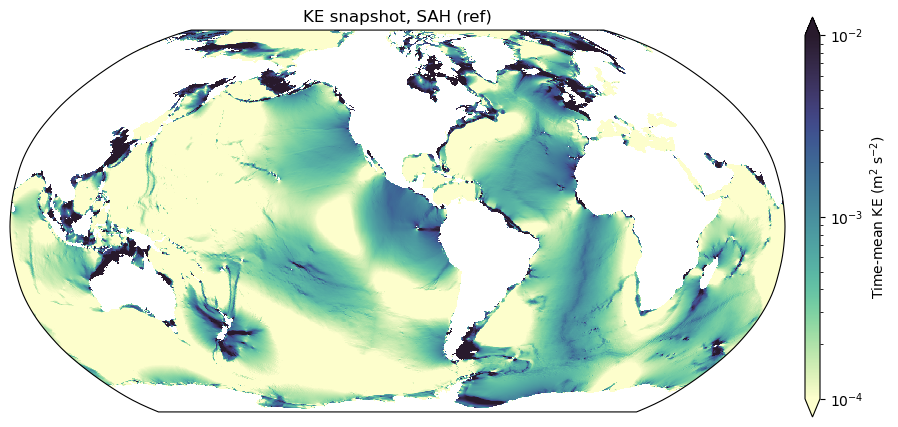

In [11]:
title = 'KE snapshot, SAH (ref)'
plot_KE(ds_ref,1e-4,1e-2,title)
plt.savefig('/g/data/nm03/lxy581/exps_figs/KE_snap_SAH_ref_no_freq_025.png', dpi=300, bbox_inches='tight')

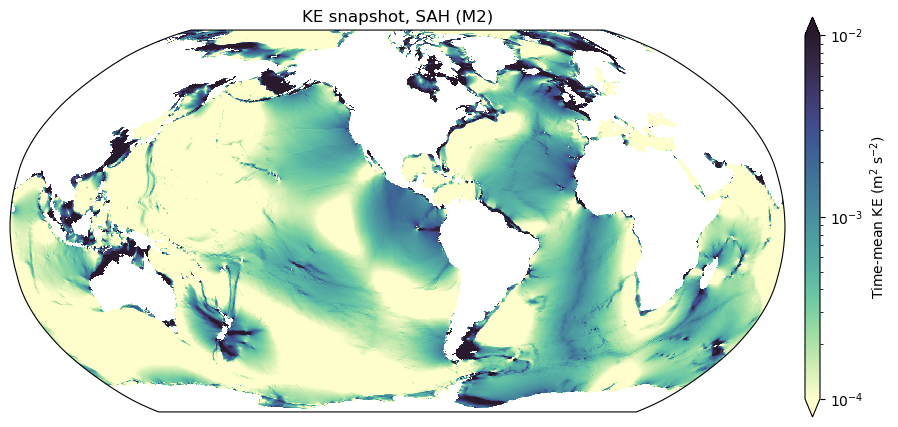

In [12]:
title = 'KE snapshot, SAH (M2)'
plot_KE(ds_SAH,1e-4,1e-2,title)
plt.savefig('/g/data/nm03/lxy581/exps_figs/KE_snap_SAH_freq_M2_025.png', dpi=300, bbox_inches='tight')

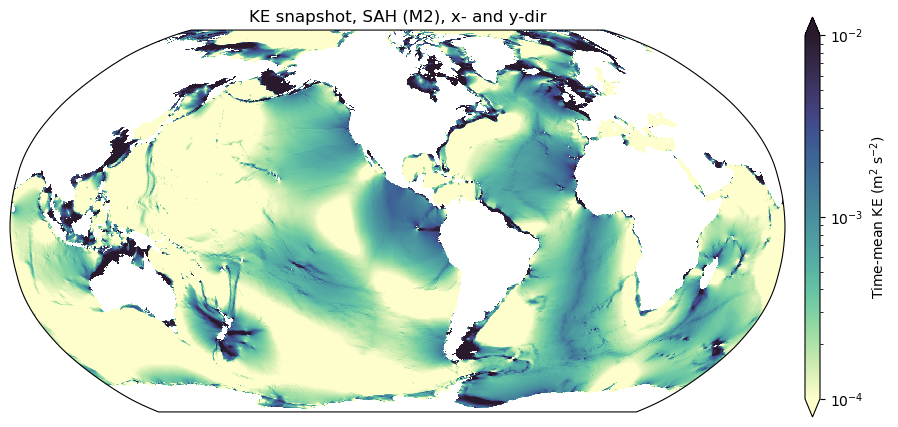

In [13]:
title = 'KE snapshot, SAH (M2), x- and y-dir'
plot_KE(ds_x_y,1e-4,1e-2,title)
plt.savefig('/g/data/nm03/lxy581/exps_figs/KE_snap_SAH_freq_M2_x_y_025.png', dpi=300, bbox_inches='tight')

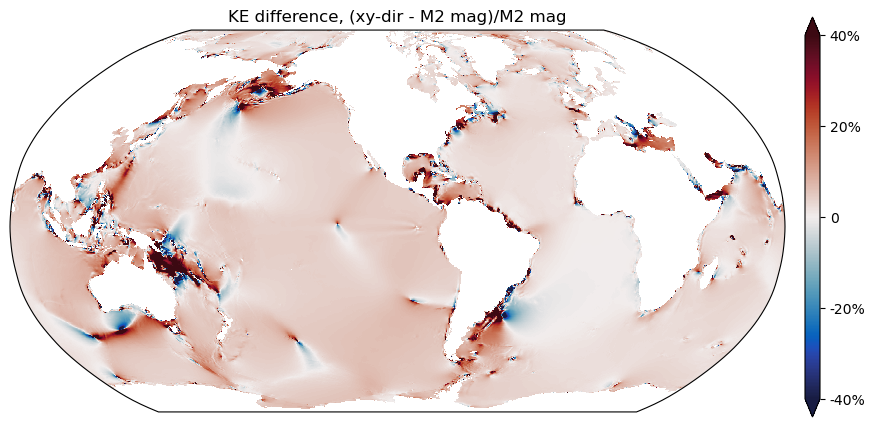

In [14]:
title = 'KE difference, (xy-dir - M2 mag)/M2 mag'
tick_locs = np.array([-0.4,-0.2,0,0.2,0.4])
tick_labels = np.array(["-40%","-20%",0,"20%","40%"])
plot_KE_lin(ds_ref["lon"],ds_ref["lat"],(ds_x_y["KE"]-ds_SAH["KE"])/ds_SAH["KE"],-0.4,0.4,title,tick_locs,tick_labels)
plt.savefig('/g/data/nm03/lxy581/exps_figs/KE_diff_SAH_M2_x_y_mag_025.png', dpi=300, bbox_inches='tight')